### Imgage Clssification Image recognition
1) Creating a deep learning model for classifying Cats and Dogs
* [VGG16](#)
2) Tune parameters with
- Dropouts
- Early Stoppings
- Callbacks
- Augumentation
- Other Regularizations



# Importing Libraries

In [ ]:
# import numpy as np
# import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import cv2
# from tensorflow.keras.preprocessing import image
# import os
# from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam
 

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
 

2024-11-30 05:06:41.936181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 05:06:41.936255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 05:06:41.939428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 05:06:41.958531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 05:06:42.867970: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-30 05:06:44.320348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 05:06:44.451283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 05:06:44.451355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


**Defining size**

In [3]:
batch_size = 32
# img_height = 224
# img_width = 224

## Data Processing, Data Generation

In [ ]:
# Construct an instance of the ImageDataGenerator class
# Pass the augmentation parameters through the constructor. 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.20
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.20
)

In [ ]:
train_data_dir='data_ingestion/Cats_and_Dog_Images/train'
test_data_dir='data_ingestion/Cats_and_Dog_Images/test'

train = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=123,
    subset='training',
    interpolation="bilinear"
)

val = valid_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    subset='validation',
    interpolation="bilinear"
)


Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


**Size**

In [6]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 2)


# Training Models

**VGG16 Model**

In [ ]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(224,224,3),
                   pooling='max',
                   classes=2)


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5)) # Dropouts

VGG_model.add(Dense(2, activation='softmax'))
pretrained_model.trainable=False

In [13]:
VGG_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                      

## Callbacks

In [15]:


#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 

#Give unique name to save all models as accuracy improves
# filepath="model/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.

#Overwrite the model each time accuracy improves. Saves a lot of space. 
filepath="model/best_model_cats_dogs.hdf5"
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for five consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [16]:
# Fit model

epochs=15
steps_per_epoch = train.samples // train.batch_size
validation_steps = val.samples // val.batch_size
history = VGG_model.fit(
  train,
  epochs=epochs,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  validation_data=val,
  callbacks=callbacks_list,
  verbose=1
)

Epoch 1/15


2024-11-30 05:08:37.471594: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9578d04de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 05:08:37.471659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-30 05:08:37.482233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732943317.600303    7490 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.6916
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to model/best_model_cats_dogs.hdf5


/home/datas/miniconda3/envs/tf15/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 22s 2s/step - loss: 0.7152 - accuracy: 0.6916 - val_loss: 0.3730 - val_accuracy: 0.8542
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8217
Epoch 2: val_accuracy did not improve from 0.85417
13/13 [==============================] - 11s 856ms/step - loss: 0.4278 - accuracy: 0.8217 - val_loss: 0.3226 - val_accuracy: 0.8438
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8578
Epoch 3: val_accuracy did not improve from 0.85417
13/13 [==============================] - 11s 872ms/step - loss: 0.3213 - accuracy: 0.8578 - val_loss: 0.4569 - val_accuracy: 0.7708
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8843
Epoch 4: val_accuracy improved from 0.85417 to 0.88542, saving model to model/best_model_cats_dogs.hdf5
13/13 [==============================] - 15s 1s/step - loss: 0.3151 - accuracy: 0.8843 - val_loss: 0.2529 - val_accurac

In [18]:
# evaluating the model
steps_per_epoch = train.samples // train.batch_size
validation_steps = val.samples // val.batch_size
train_loss, train_acc = VGG_model.evaluate(train, steps=steps_per_epoch)
validation_loss, test_acc = VGG_model.evaluate(val, steps=validation_steps)
print('Train Accuracy: %.3f , Train Loss: %.3f' % (train_acc * 100.0 , train_loss * 100.0),'%')
print('Test Accuracy: %.3f , Validation loss: %.3f' % (test_acc * 100.0 , validation_loss * 100.0),'%')

3/3 [==============================] - 1s 385ms/step - loss: 0.3447 - accuracy: 0.8333
Train Accuracy: 87.260 , Train Loss: 27.286 %
Test Accuracy: 83.333 , Validation loss: 34.473 %


**Ploting Loss and Accuracy**

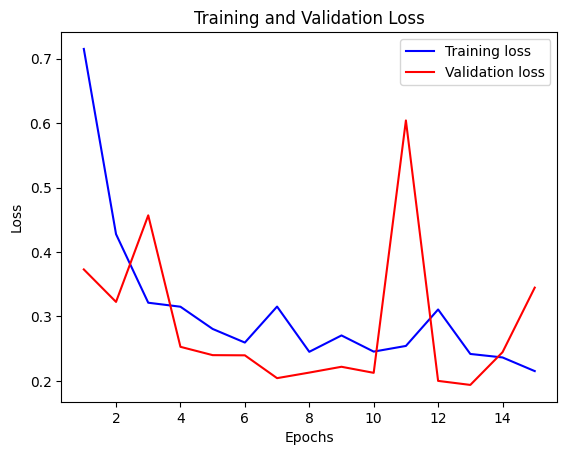

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

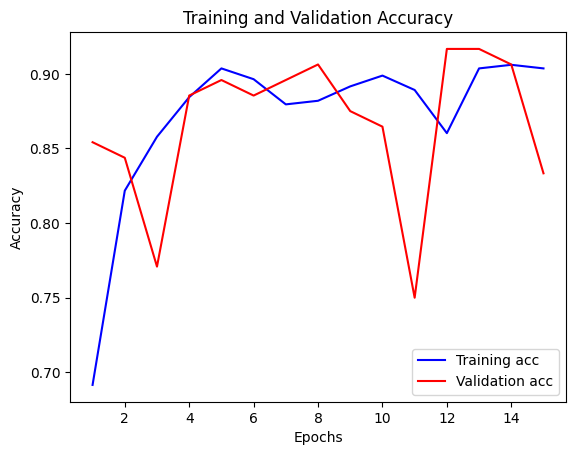

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Saving and loading models
VGG_model.save("model/model_cats_dogs.h5")


### load model and test